In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import os
from astropy.io import fits
import scipy.interpolate
from scipy.interpolate import splev, splrep
from scipy import interpolate
import scipy.interpolate as spi

In [2]:
def new_degrade_R(input_wl, input_fl, wl_range, Res):
    ''' using established routine from the python module “coronagraph”
    '''
    import coronagraph as cg
    lowres_wl, lowres_dwl = cg.noise_routines.construct_lam(wl_range[0], wl_range[1], Res=Res)
    lowres_fl = cg.downbin_spec(input_fl, input_wl, lowres_wl, dlam=lowres_dwl)
    return lowres_wl, lowres_fl

In [3]:
# Load CSV File
df = pd.read_csv('/Users/bosse/Pictures/benchmark_taurus2022.csv')
df

name_benchmark                    flag_benchmark  \
0       2MASS J05575096-1359503                        lowg;young   
1       2MASS J23520507-1100435                              lowg   
2         CC_CCv2.0_4795_107418                      COCONUTS_OLD   
3         CC_CCv2.0_68871_71463                    COCONUTS_YOUNG   
4        2MASSI J0335020+234235  BPMG;Li;strongHa;accr;lowg;young   
..                          ...                               ...   
154                    HD 3651B                ultracoolsheet_OLD   
155    ULAS J141623.94+134836.3                ultracoolsheet_OLD   
156  WISEPC J225540.74-311841.8                      v-red;young?   
157                BD +01 2920B                ultracoolsheet_OLD   
158                   Ross 458C              ultracoolsheet_YOUNG   

     sep_companion_benchmark  spt_benchmark  ra_benchmark  dec_benchmark  \
0                        NaN            7.0       89.4624     -13.997300   
1                        NaN            7.0      358.0211     -11.012200   
2                     167.41            7.5      192.6987     -15.668200   
3                      35.29            7.5      198.7383      58.737100   
4                        NaN            8.5       53.7587      23.709801   
..                       ...            ...           ...            ...   
154                    42.90           27.5        9.8288      21.254700   
155                     9.80           27.5      214.0995      13.809900   
156                      NaN           28.0      343.9198     -31.311701   
157                   153.00           28.0      215.8369       1.277100   
158                   103.00           28.0      195.1735      12.354000   

     J_2MASS_benchmark  J_err_2MASS_benchmark ref_J_2MASS_benchmark  \
0            12.871000                  0.023                Cutr03   
1            12.840000                  0.022                Cutr03   
2                  NaN                    NaN   2003tmc..book.....C   
3            14.414000                  0.035   2003tmc..book.....C   
4            12.250000                  0.021                Cutr03   
..                 ...                    ...                   ...   
154          16.594999                  0.030   2012ApJS..201...19D   
155          17.632999                  0.020   2012ApJS..201...19D   
156          17.290001                  0.070                Kirk11   
157                NaN                    NaN                   NaN   
158          16.980000                  0.010   2016ApJ...833...96L   

     H_2MASS_benchmark  ...                      ref_K_MKO_benchmark  \
0            12.145000  ...                                   Best21   
1            12.166000  ...                                   Best21   
2                  NaN  ...  2012yCat.2314....0L,2018MNRAS.473.5113D   
3            13.763000  ...  2012yCat.2314....0L,2018MNRAS.473.5113D   
4            11.655000  ...                                   Lawr12   
..                 ...  ...                                      ...   
154          16.660999  ...                      2007ApJ...654..570L   
155          17.552999  ...                      2021AJ....161...42B   
156          17.700001  ...                                   Best21   
157                NaN  ...                      2012MNRAS.422.1922P   
158          16.959999  ...                      2012yCat.2314....0L   

    W1_benchmark  W1_err_benchmark  W2_benchmark W2_err_benchmark  \
0      11.240000             0.023        10.596            0.019   
1      11.463000             0.023        11.151            0.021   
2      15.609000             0.047        15.271            0.092   
3      13.158000             0.024        12.929            0.025   
4      11.056000             0.084        10.774            0.020   
..           ...               ...           ...              ...   
154          NaN               NaN           NaN              NaN   
155  

In [4]:
# Finding the number of objects
name_object = df.name_benchmark.values
spectrum_path = df.spectra_filename.values
num_object = len(name_object)
print(num_object)

159


In [5]:
direc = '/Users/bosse/Pictures/Primary Grid Models/'
teff_grid = np.array([800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400])
num_teff = len(teff_grid)
logg_grid = np.array([4,4.5,5,5.5])
num_logg = len([logg_grid])
logg_dict = {4:"100",
            4.5:"300",
            5:"1000",
            5.5:"3000"}
f_sed_dict = {1:"f1",
             2:"f2",
             3:"f3",
             4:"f4",
             10:"nc"}
f_sed_grid = np.array([1,2,3,4,10])
num_f_sed = len([f_sed_grid])
num_model = num_teff * num_logg * num_f_sed
grid_param = []
for teff in teff_grid:
    for logg in logg_grid:
        for f in f_sed_grid:
            grid_param.append([teff, logg, f])
grid_param = np.array(grid_param)
print(grid_param)
num_model = len(grid_param)
print(num_model)

[[8.0e+02 4.0e+00 1.0e+00]
 [8.0e+02 4.0e+00 2.0e+00]
 [8.0e+02 4.0e+00 3.0e+00]
 ...
 [2.4e+03 5.5e+00 3.0e+00]
 [2.4e+03 5.5e+00 4.0e+00]
 [2.4e+03 5.5e+00 1.0e+01]]
340


In [6]:
exist_flag = np.ones(num_model)
for index in range(num_model):
    teff, logg, f = grid_param[index]
    Model_folder = '/Users/bosse/Pictures/Primary Grid Models/'
    try:
        model_array = np.genfromtxt(Model_folder + "sp_t%dg%s%s"%(teff, logg_dict[logg], f_sed_dict[f]), skip_header = 2)
    except OSError or FileNotFoundError:
#Downgrade Resolution then Model Interpolation
        print("sp_t%dg%s%s not there"%(teff, logg_dict[logg], f_sed_dict[f]))
        exist_flag[index] = 0
        continue

sp_t800g100f1 not there
sp_t800g100f3 not there
sp_t800g100f4 not there
sp_t900g100f3 not there
sp_t900g100f4 not there
sp_t900g1000f1 not there
sp_t1000g100f1 not there
sp_t1000g100f3 not there
sp_t1000g100f4 not there
sp_t1000g300f1 not there
sp_t1200g1000f1 not there
sp_t1200g1000f2 not there
sp_t1300g300f1 not there
sp_t1400g100f1 not there
sp_t1400g1000f1 not there
sp_t1500g100f1 not there
sp_t1500g100f2 not there
sp_t1500g100f3 not there
sp_t1500g100f4 not there
sp_t1500g300f2 not there
sp_t1600g100f1 not there
sp_t1600g100f2 not there
sp_t1600g100f4 not there
sp_t1600g300f1 not there
sp_t1600g3000f1 not there
sp_t1600g3000f2 not there
sp_t1600g3000f3 not there
sp_t1700g100f1 not there
sp_t1700g100f2 not there
sp_t1700g100f4 not there
sp_t1700g1000f1 not there
sp_t1800g100f1 not there
sp_t1800g100f3 not there
sp_t1800g3000f2 not there
sp_t1900g100f1 not there
sp_t1900g100f3 not there
sp_t1900g100f4 not there
sp_t2000g100f1 not there
sp_t2000g100f3 not there
sp_t2000g100f4 not the

In [7]:
id_exist = np.where(exist_flag == 1)
grid_param = grid_param[id_exist]

In [8]:
num_model = len(grid_param)
print(num_model)

288


In [9]:
# Creating Gk and Ck values as 2D arrays
G_k_array = np.ones((num_object, num_model)) * np.nan 
C_k_array = np.ones((num_object, num_model)) * np.nan

In [10]:
for index_object in range(num_object):
    current_object_name = name_object[index_object]
    print('%d/%d:%s'%(index_object + 1, num_object, current_object_name))
    
    # Load object spectra and names
    current_spectra_path = spectrum_path[index_object]
    txt_flag = True
    if current_spectra_path[-4:] == "fits":
        txt_flag = False
    current_fullspectra_path = '/Users/bosse/Pictures/Observed Spectra files/' + current_spectra_path
    if txt_flag: 
        data = np.loadtxt(current_fullspectra_path)
        w_data = data[:,0]
        f_data = data[:,1]
        u_data = data[:,2]
    else: 
        data = fits.open(current_fullspectra_path)[0].data
        w_data = data[0]
        f_data = data[1]
        u_data = data[2]
    id_good = np.where((np.isnan(f_data) == False) & (u_data != 0) & (w_data > 0.8) & (w_data < 2.5))
    w_data = w_data[id_good]
    f_data = f_data[id_good]
    u_data = u_data[id_good]
    for index_model in range(num_model):
        teff, logg, f = grid_param[index_model]
        Model_folder = '/Users/bosse/Pictures/Primary Grid Models/'
# Load Model
        model_array = np.genfromtxt(Model_folder + "sp_t%dg%s%s"%(teff, logg_dict[logg], f_sed_dict[f]), skip_header = 2)
        w_model = model_array[:,0]
        f_model = model_array[:,1]
        (new_w_model, new_f_model) = new_degrade_R(input_wl = w_model, input_fl = f_model, wl_range = [0.8,2.5], Res = 100)
        intfunc = spi.interp1d(new_w_model, new_f_model, fill_value="extrapolate")
        f_model_interp = intfunc(w_data)
        C_knum = np.nansum(f_data * f_model_interp / u_data**2)
        #C_knum = 0
        #for i in range(num_pixels):
            #v = f_data[i] * f_model_interp[i] / u_data[i]**2
            #C_knum = C_knum + v
        C_kden = np.nansum((f_model_interp**2)/(u_data**2))
        #for i in range(num_pixels):
            #v2 = (f_model_interp[i]**2)/(u_data[i]**2)
            #C_kden = C_kden + v2
        C_k = C_knum/C_kden
        G_k = np.nansum(((f_data - C_k * f_model_interp) / (u_data))**2)
        #for i in range(num_pixels):
            #v3 = ((f_data[i] - C_k * f_model_interp[i]) / u_data[i])**2
            #G_k = G_k + v3
        C_k_array[index_object, index_model] = C_k
        G_k_array[index_object, index_model] = G_k

1/159:2MASS J05575096-1359503
2/159:2MASS J23520507-1100435
3/159:CC_CCv2.0_4795_107418


 ############################## Xspextool History ############################## [astropy.io.fits.card]
 ############################## Xcombspec History ############################## [astropy.io.fits.card]
 ############################### Xtellcor History ############################## [astropy.io.fits.card]


4/159:CC_CCv2.0_68871_71463
5/159:2MASSI J0335020+234235
6/159:2MASS J06085283-2753583
7/159:2MASS J23231347-0244360
8/159:CC_CCv2.0_29902_75473
9/159:2MASS J00464841+0715177
10/159:2MASS J04433761+0002051
11/159:SDSS J102204.88+020047.5
12/159:2MASS J12474428-3816464
13/159:DENIS-P J154747.2-242349
14/159:2MASS J19355595-2846343
15/159:2MASS J20135152-2806020
16/159:PSO J337.4317+16.4213
17/159:2MASS J23453903+0055137
18/159:CC_CCv2.0_31709_104612
19/159:CC_CCv2.0_97406_93436
20/159:PC 0025+0447
21/159:EROS-MP J0032-4405
22/159:2MASSW J0058425-065123
23/159:2MASS J02411151-0326587
24/159:2MASSI J0316451-284852
25/159:2MASS J03231002-4631237
26/159:DENIS-P J035726.9-441730
27/159:2MASS J09532126-1014205
28/159:2MASS J11544223-3400390
29/159:2MASS J12074836-3900043
30/159:2MASSW J1552591+294849
31/159:PSO J348.8808+06.2873
32/159:2MASS J23224684-3133231
33/159:1RXS J235133.3+312720 B
34/159:G 239-25B
35/159:HD 89744B
36/159:SDSS J004154.54+134135.5
37/159:SDSS J085836.98+271050.8
38/159

In [11]:
np.save('/Users/bosse/Pictures/C_k and G_k values/All C_k and G_k Values/all_Ck.npy', C_k_array)
np.save('/Users/bosse/Pictures/C_k and G_k values/All C_k and G_k Values/all_Gk.npy', G_k_array)
np.save('/Users/bosse/Pictures/C_k and G_k values/All C_k and G_k Values/all_grid_param.npy', grid_param)
C_k_array = np.load('/Users/bosse/Pictures/C_k and G_k values/All C_k and G_k Values/all_Ck.npy')
G_k_array = np.load('/Users/bosse/Pictures/C_k and G_k values/All C_k and G_k Values/all_Gk.npy')
grid_param = np.load('/Users/bosse/Pictures/C_k and G_k values/All C_k and G_k Values/all_grid_param.npy')

1/159:2MASS J05575096-1359503
7.867234284867238e-10 0.9999999999999997


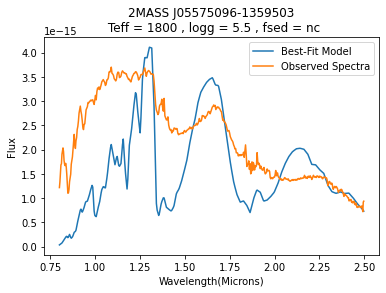

2/159:2MASS J23520507-1100435
4.765897512804136e-10 1.0000000000000002


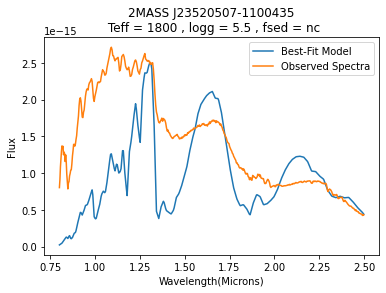

3/159:CC_CCv2.0_4795_107418
2.318506881156398e-12 0.9999999999999997


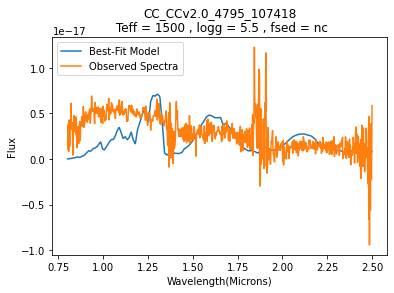

4/159:CC_CCv2.0_68871_71463
1.727022531040047e-10 1.0


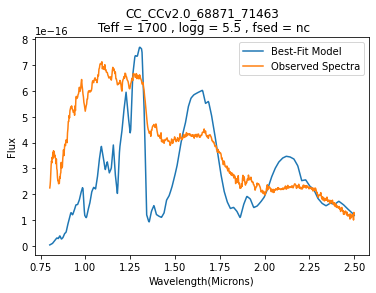

5/159:2MASSI J0335020+234235
2.8224699870141165e-09 0.9999999999999998


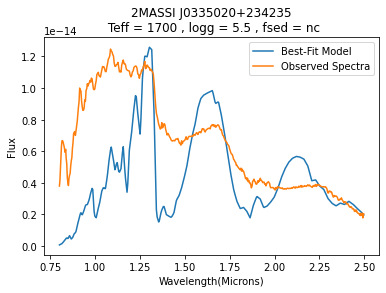

6/159:2MASS J06085283-2753583
7.469824479923988e-10 0.9999999999999998


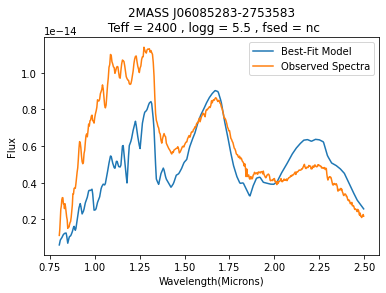

7/159:2MASS J23231347-0244360
3.042107408773404e-10 0.9999999999999997


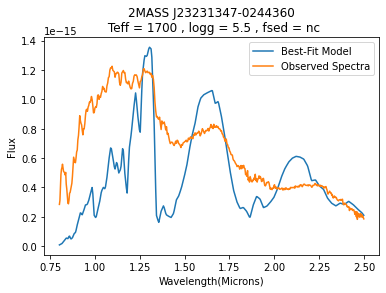

8/159:CC_CCv2.0_29902_75473
3.2530176134271745e-11 1.0000000000000002


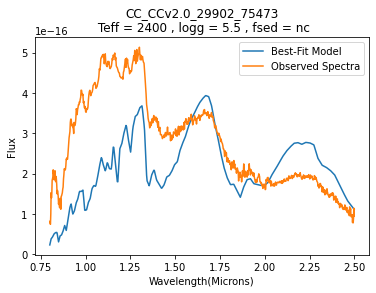

9/159:2MASS J00464841+0715177
63049.26602842423 1.0000000000000004


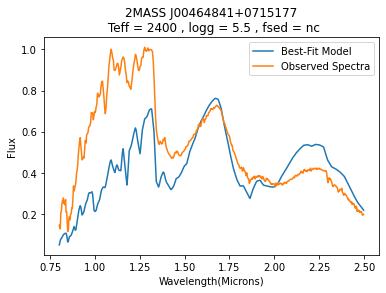

10/159:2MASS J04433761+0002051
2.037193697906139e-10 1.0000000000000002


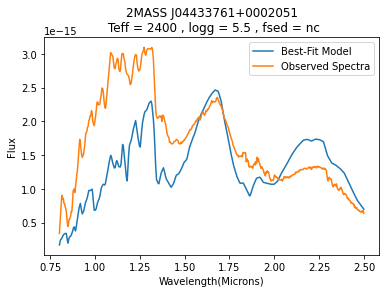

11/159:SDSS J102204.88+020047.5
68902.7316443922 1.0000000000000002


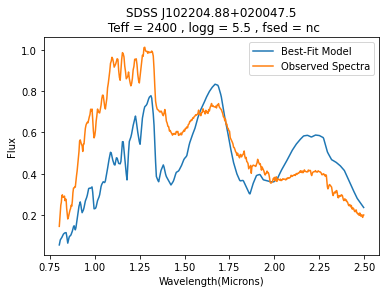

12/159:2MASS J12474428-3816464
1.0660819095017116e-10 1.0000000000000002


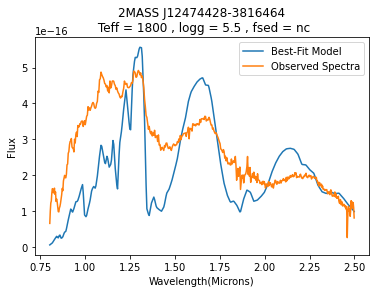

13/159:DENIS-P J154747.2-242349
207944.30144578312 1.0


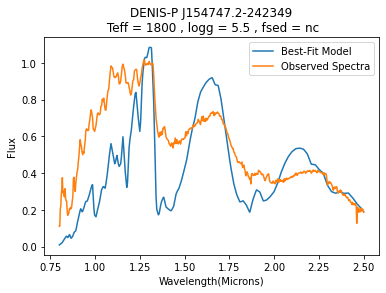

14/159:2MASS J19355595-2846343
8.401217691803317e-11 1.0000000000000002


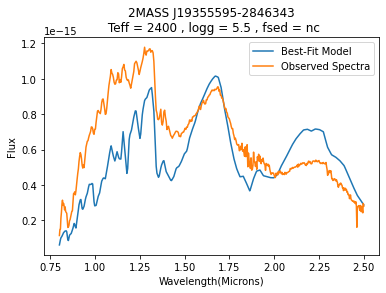

15/159:2MASS J20135152-2806020
6.712232430299758e-11 1.0000000000000002


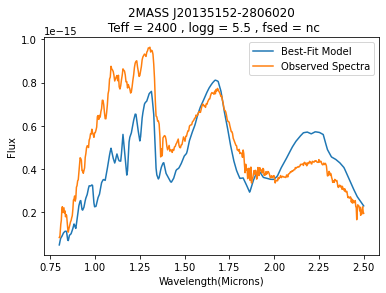

16/159:PSO J337.4317+16.4213
9.998338924317159e-12 1.0


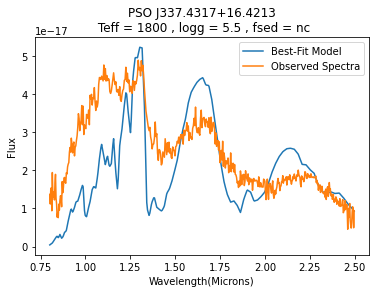

17/159:2MASS J23453903+0055137
63973.96404448718 1.0


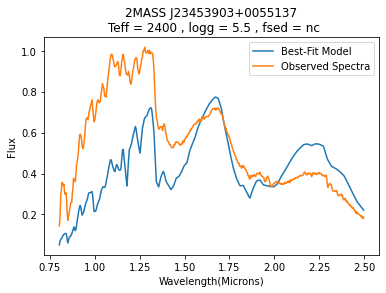

18/159:CC_CCv2.0_31709_104612
5.013967584370795e-11 0.9999999999999998


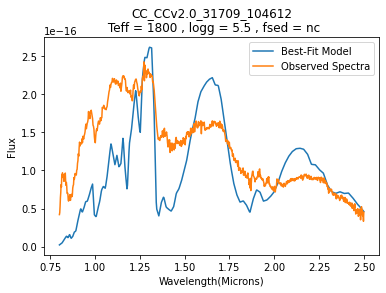

19/159:CC_CCv2.0_97406_93436
3.313660631584197e-11 1.0


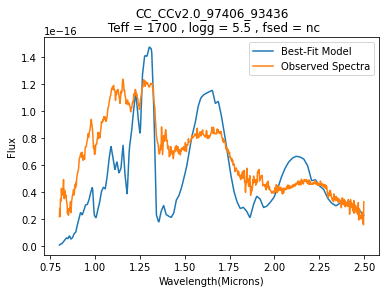

20/159:PC 0025+0447
2.6850016593450652e-11 1.0


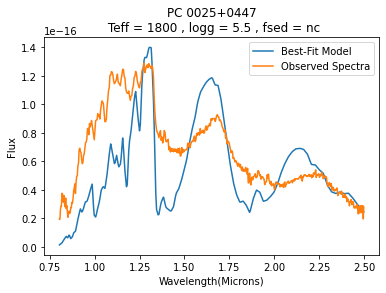

21/159:EROS-MP J0032-4405
2.7389660071798805e-11 1.0


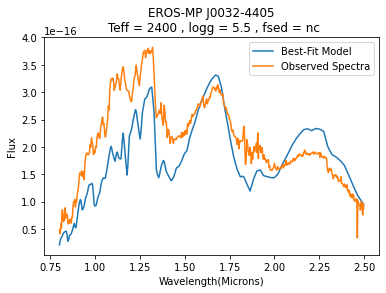

22/159:2MASSW J0058425-065123
69232.59405196496 1.0


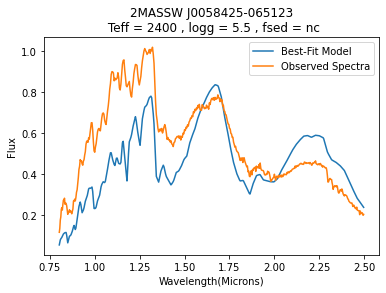

23/159:2MASS J02411151-0326587
1.0046173799232729e-11 1.0


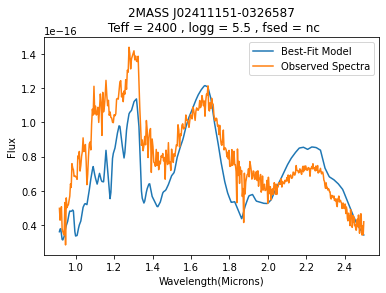

24/159:2MASSI J0316451-284852
1.0629703166755168e-10 1.0000000000000002


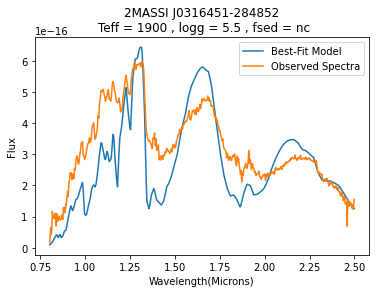

25/159:2MASS J03231002-4631237
4.115256046224555e-11 0.9999999999999998


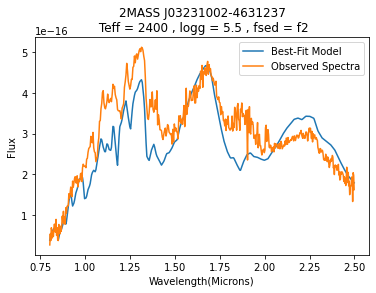

26/159:DENIS-P J035726.9-441730
72471.57993141084 1.0


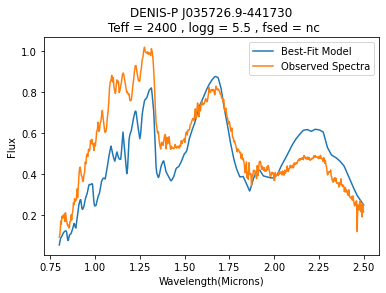

27/159:2MASS J09532126-1014205
2.115087360179803e-09 1.0000000000000002


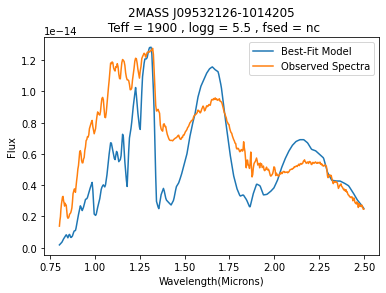

28/159:2MASS J11544223-3400390
5.991750587723578e-11 1.0000000000000002


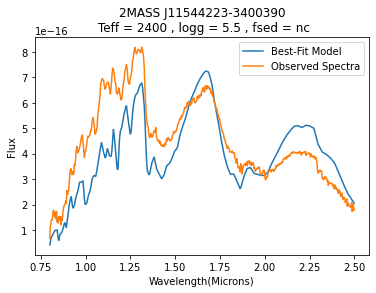

29/159:2MASS J12074836-3900043
5.782719276603382e-11 1.0


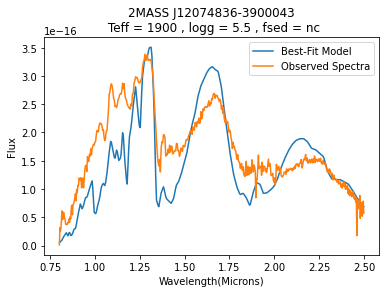

30/159:2MASSW J1552591+294849
70549.02917021293 1.0


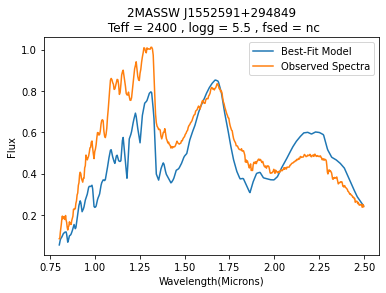

31/159:PSO J348.8808+06.2873
1.3659363956295039e-11 1.0000000000000002


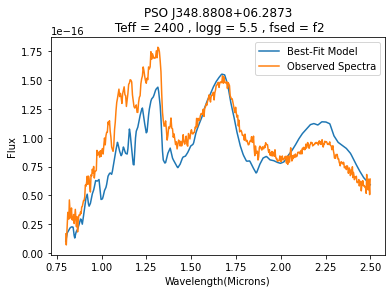

32/159:2MASS J23224684-3133231
2.683199788466057e-09 1.0


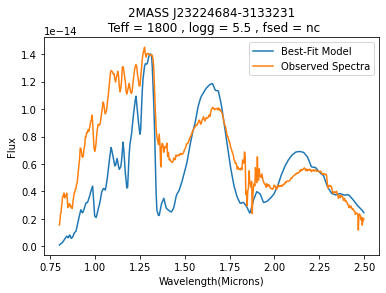

33/159:1RXS J235133.3+312720 B
8.93415681739517e-11 1.0000000000000002


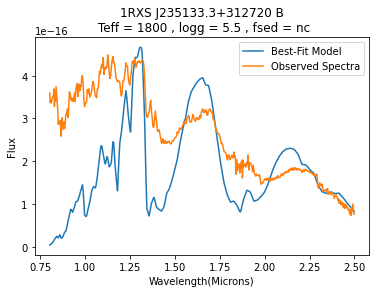

34/159:G 239-25B
2.7693364852534968e-09 1.0


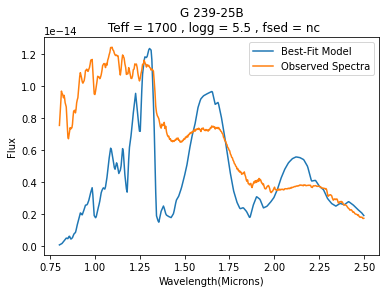

35/159:HD 89744B
67799.61315580984 1.0000000000000002


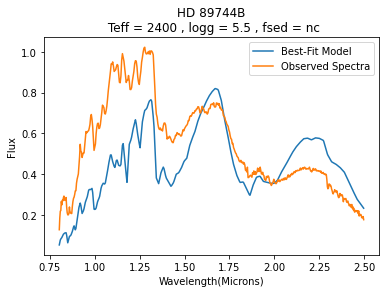

36/159:SDSS J004154.54+134135.5
9.983880208177526e-10 0.9999999999999999


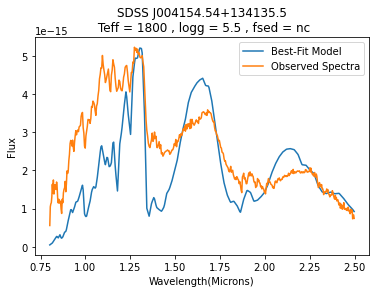

37/159:SDSS J085836.98+271050.8
6.880175892924051e-11 0.9999999999999999


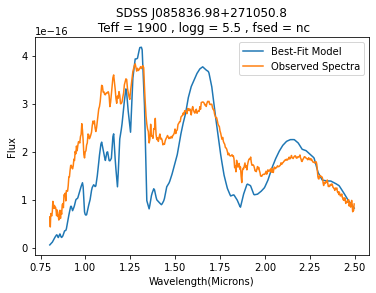

38/159:2MASSW J0147334+345311
66288.27677302652 1.0000000000000004


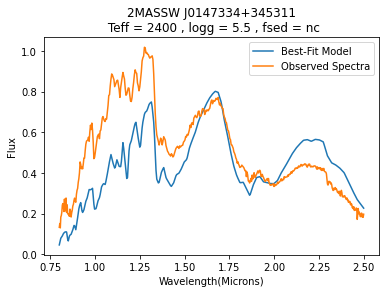

39/159:HD 253662B
1.0332912785482695e-11 1.0000000000000002


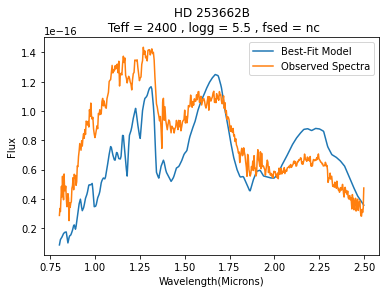

40/159:HIP 2397B
1.1821807784690075e-10 1.0000000000000002


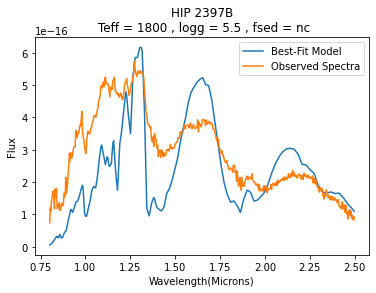

41/159:2MASS J05184616-2756457
2.2469376316812542e-11 0.9999999999999998


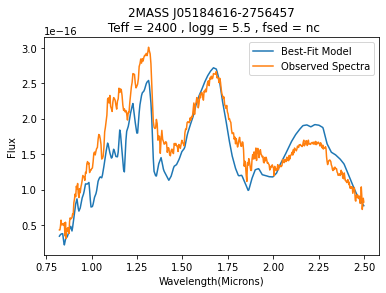

42/159:WISE J052857.68+090104.4
75003.76226268482 1.0


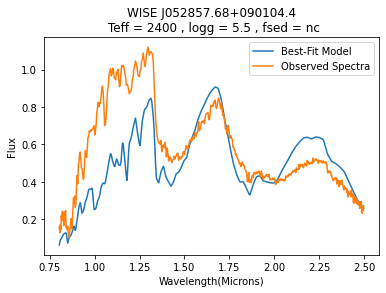

43/159:2MASS J05431887+6422528
178338.97055924634 1.0


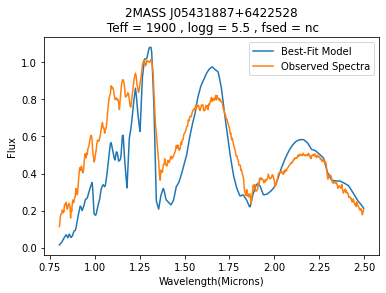

44/159:LSR J0602+3910
3.362913362839454e-10 0.9999999999999998


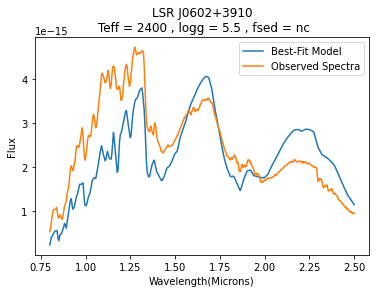

45/159:2MASS J10224821+5825453
208587.04728298687 1.0


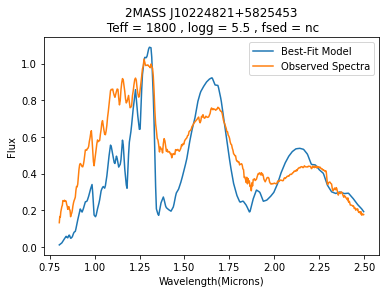

46/159:2MASS J00135882-1816462
3.7436910425223085e-11 1.0


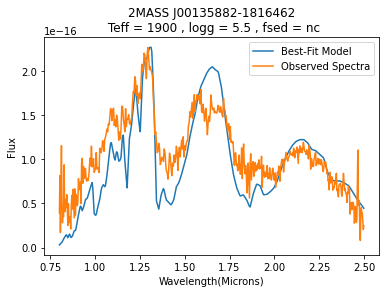

47/159:CC_CCv2.0_30145_32042
3.0427497156078225e-13 1.0000000000000002


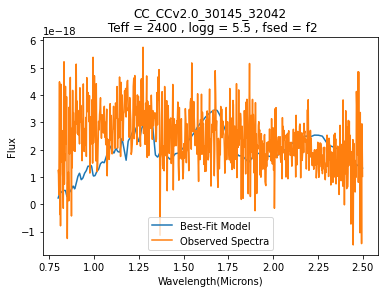

48/159:DENIS-P J144137.2-094558
69817.684203582 1.0


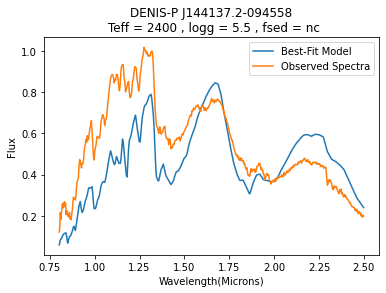

49/159:GJ 1048B
74301.28485282339 1.0


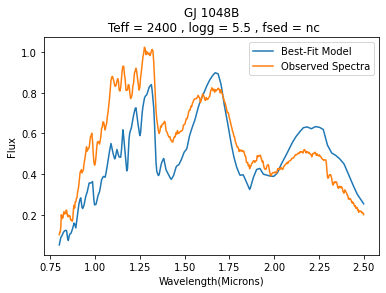

50/159:HIP 59933B
8.670160296387439e-12 0.9999999999999998


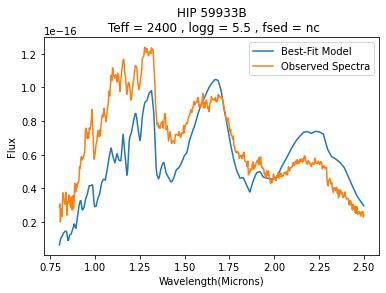

51/159:HIP 63506C
6.920537299146435e-11 0.9999999999999999


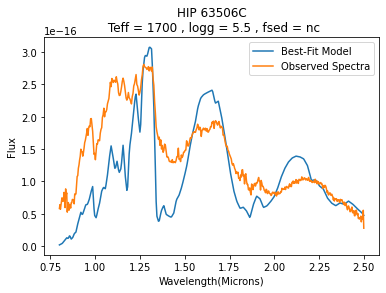

52/159:HIP 6407B
6.414314045054942e-11 1.0000000000000002


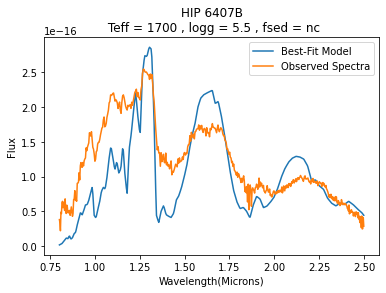

53/159:LSPM J0241+2553B
7.784973874252343e-12 1.0


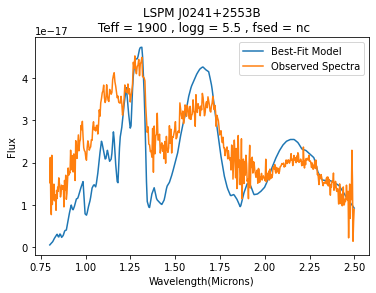

54/159:SDSS J163256.13+350507.2
1.0908389472190685e-10 1.0000000000000002


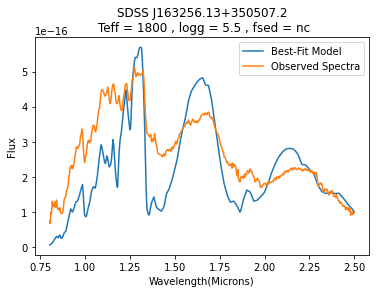

55/159:PSO J078.9904+31.0171
5.329228788884148e-12 1.0


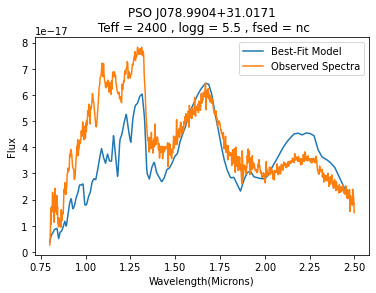

56/159:2MASSI J2057540-025230
1.0134891813269563e-10 0.9999999999999998


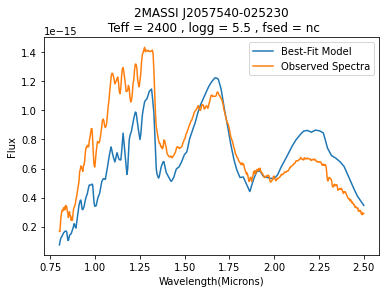

57/159:CC_CCv2.0_92852_50659
9.735663381894004e-12 1.0


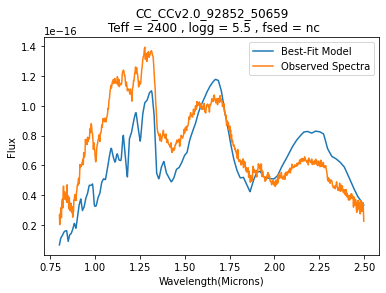

58/159:HIP 11161B
1.7588999939733936e-11 1.0000000000000004


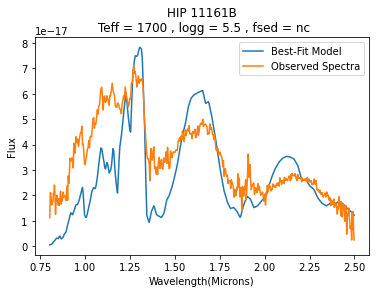

59/159:HIP 112422B
2.362521196181471e-11 1.0000000000000002


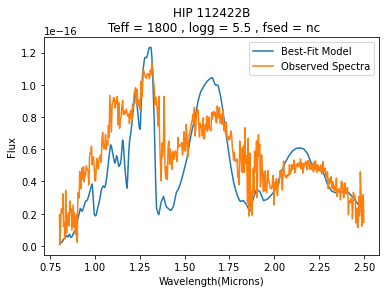

60/159:HIP 26653B
7.379802893846216e-11 1.0000000000000004


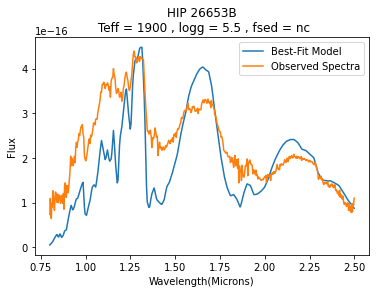

61/159:LSPM J0632+5053B
1.834262872203789e-11 0.9999999999999999


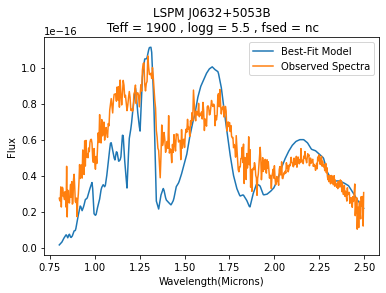

62/159:NLTT 44368B
9.732523126024244e-11 0.9999999999999998


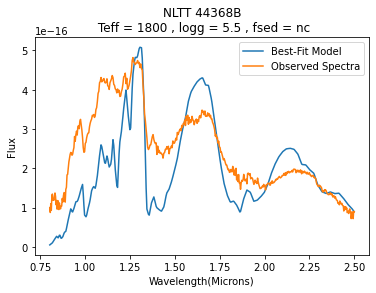

63/159:PM I13518+4157B
2.1244467484031265e-11 1.0


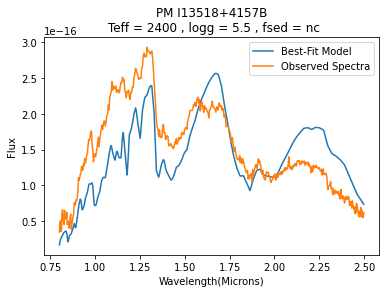

64/159:PM I22118-1005B
1.524540776318371e-11 1.0000000000000002


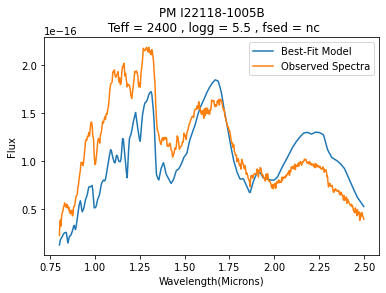

65/159:2MASS J05361998-1920396
2.0229158344407304e-11 1.0000000000000002


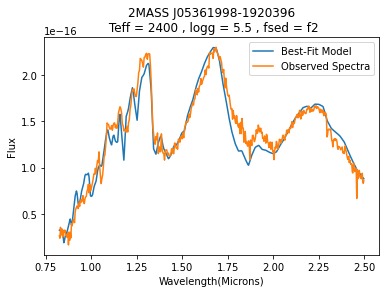

66/159:PSO J159.0433-27.6357
2.0404038843308997e-12 1.0000000000000004


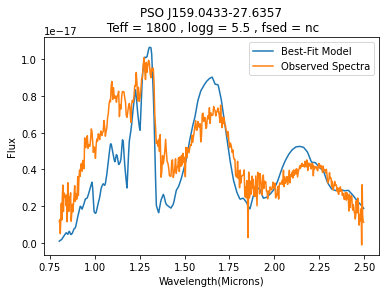

67/159:NLTT 1011B
3.6189896927110426e-11 1.0


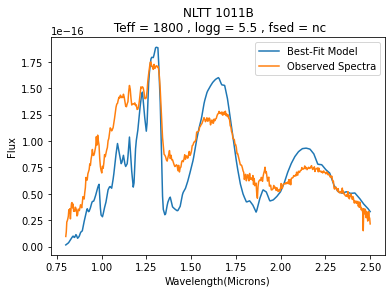

68/159:NLTT 35593B
8.301200176839808e-12 0.9999999999999998


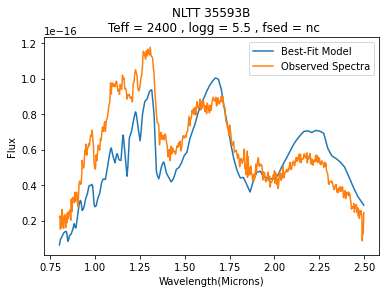

69/159:PSO J344.8146+20.1917
6.3427864063269335e-12 1.0000000000000002


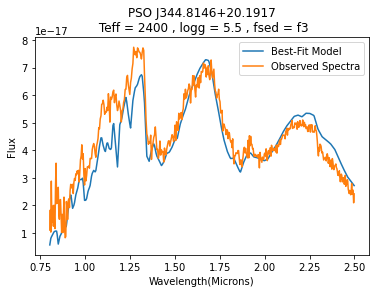

70/159:GJ 618.1B
80871.62047887132 1.0


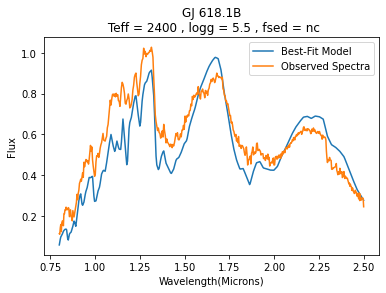

71/159:HIP 73169B
9.444353207891562e-12 1.0


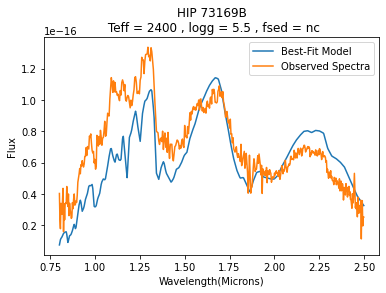

72/159:2MASS J00193927-3724392
1.3088182933183126e-10 1.0000000000000004


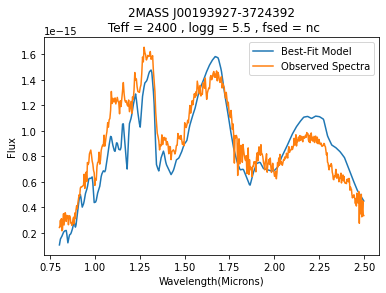

73/159:2MASSI J0453264-175154
2.691208507118049e-11 1.0000000000000002


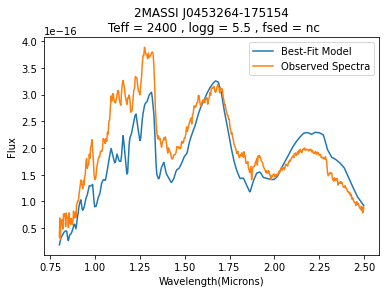

74/159:DENIS-P J142527.97-365023.4
1.083715738559927e-10 1.0


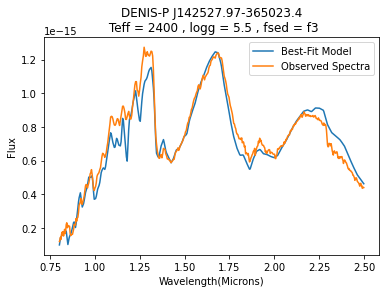

75/159:2MASSW J2208136+292121
1.2141199703388236e-11 1.0


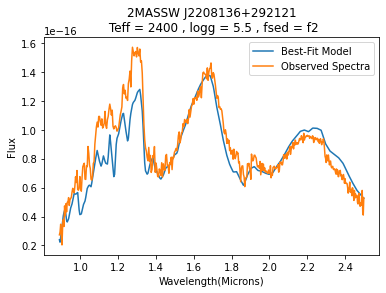

76/159:2MASS J13204427+0409045
5.1863791725817396e-11 1.0


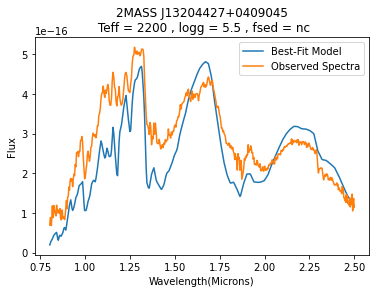

77/159:CC_CCv2.0_42422_65260
7.24058829143284e-12 1.0000000000000004


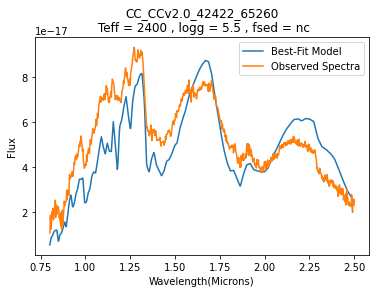

78/159:CC_CCv2.0_59129_49947
4.2121626385343595e-12 1.0000000000000002


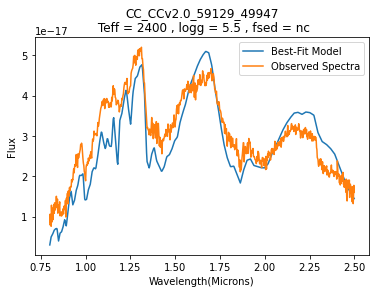

79/159:CC_CCv2.0_71561_47113
7.600718840546131e-12 1.0


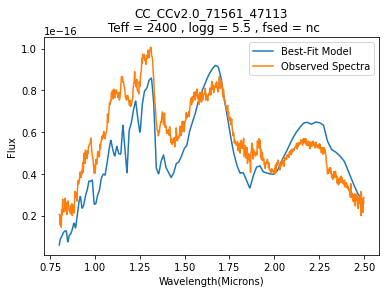

80/159:G 196-3B
108517.50931886816 1.0


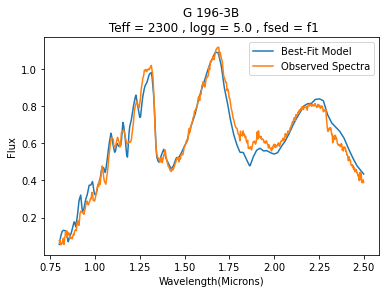

81/159:SDSS J020735.60+135556.3
78296.91472483777 1.0


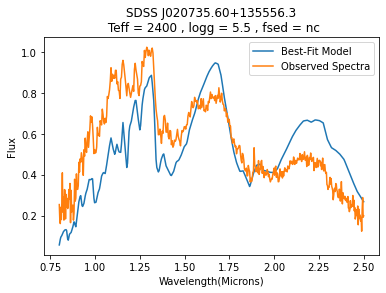

82/159:SDSSp J224953.45+004404.2
8.53165395188009e-12 1.0


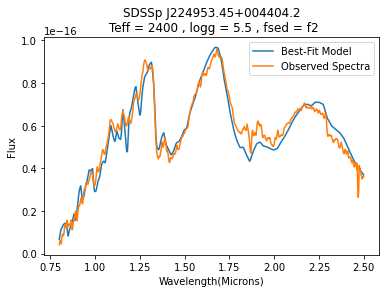

83/159:Hya12
5.3554932363161055e-12 1.0


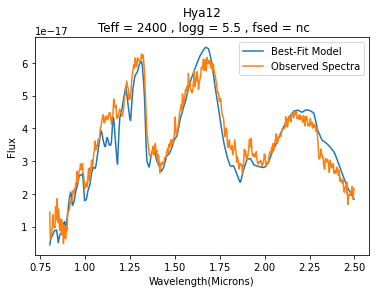

84/159:2MASS J00332386-1521309
1.909363363240932e-11 1.0000000000000002


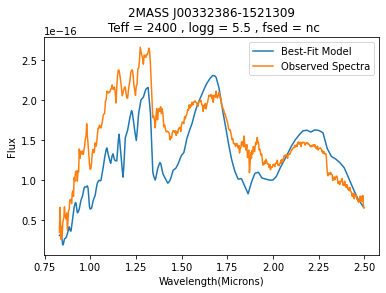

85/159:2MASS J01262109+1428057
1.0349793020103297e-10 1.0000000000000002


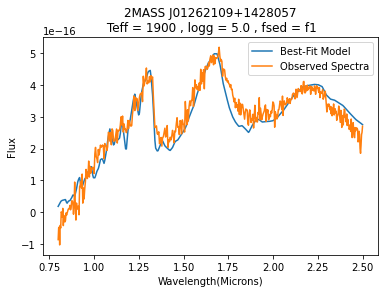

86/159:2MASS J15382417-1953116
1.6307645284369798e-10 0.9999999999999996


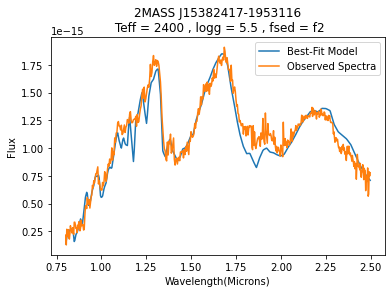

87/159:2MASS J15515237+0941148
9.312097063370139e-12 1.0


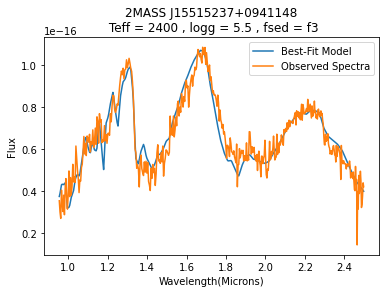

88/159:2MASS J16154255+4953211
1.6883400202139993e-10 1.0


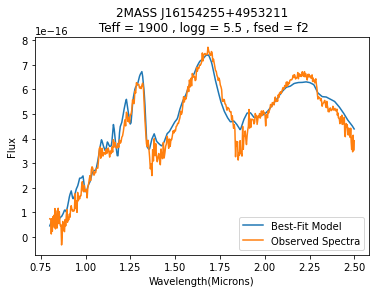

89/159:SIMP J21543454-1055308
9.497755723535844e-12 1.0


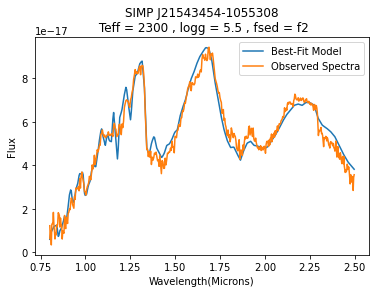

90/159:2MASSW J2206450-421721
86542.74617483492 1.0000000000000002


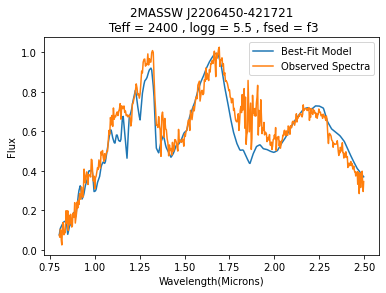

91/159:2MASSW J1004392-333518
1.0484639560290235e-10 1.0


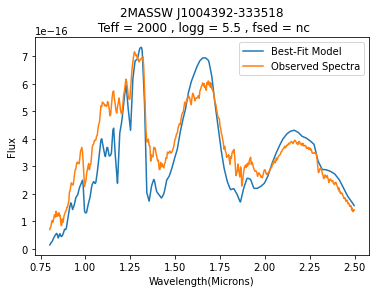

92/159:CC_CCv2.0_23479_65979
4.4013851148939626e-12 1.0000000000000004


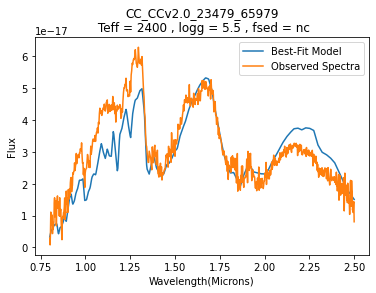

93/159:GD 165B
2.2804850320311394e-11 1.0


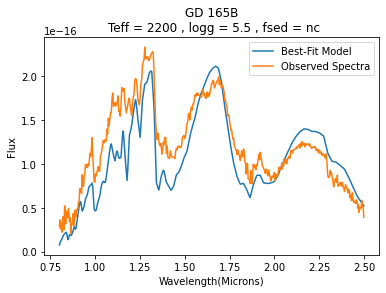

94/159:LSPM J1336+2541B
4.823542406578252e-12 0.9999999999999998


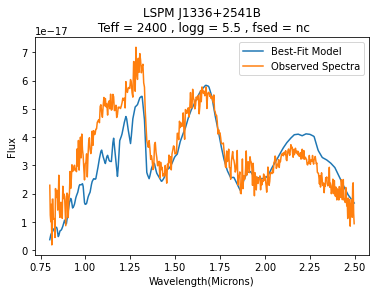

95/159:NLTT 26746B
2.1433388167483632e-11 0.9999999999999998


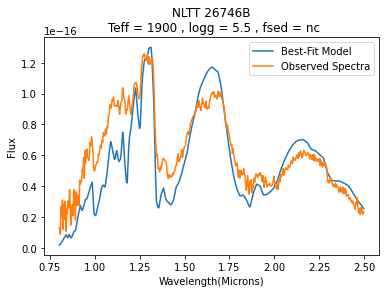

96/159:NLTT 27966B
2.385239663302399e-11 1.0


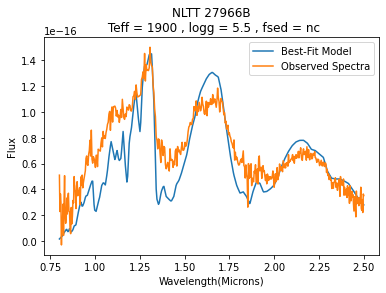

97/159:PM I13410+0542B
4.5660147709174995e-12 1.0000000000000002


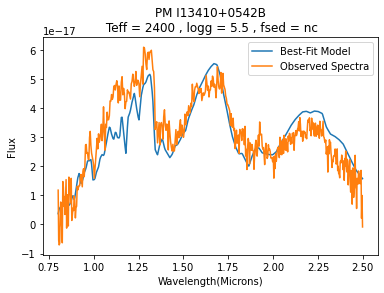

98/159:SDSS J141659.78+500626.4
91757.77306445502 0.9999999999999998


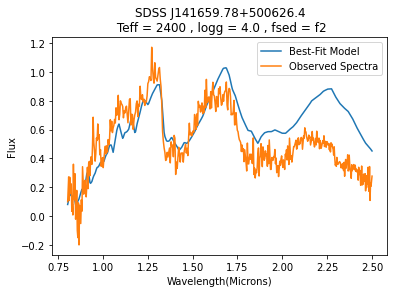

99/159:Gl 417BC
83118.41297517803 1.0


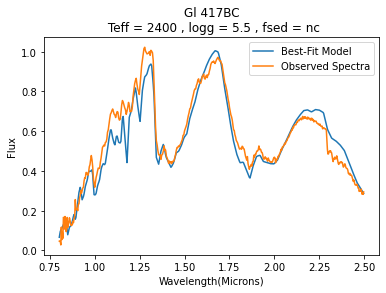

100/159:2MASS J03264225-2102057
2.3510121970193937e-11 1.0000000000000002


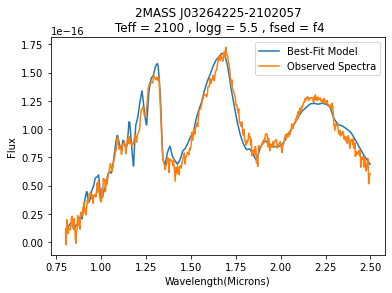

101/159:2MASS J03552337+1133437
3.268975209196227e-10 1.0


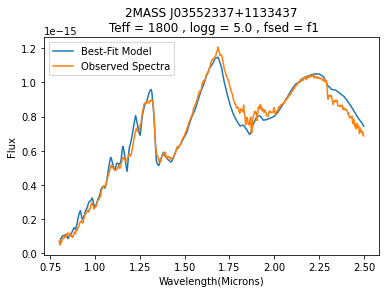

102/159:2MASSI J0512063-294954
3.472836011488995e-11 1.0000000000000004


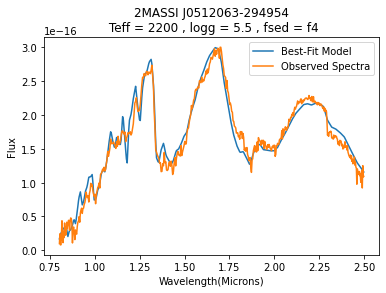

103/159:PSO J149.1907-19.1730
8.985138624755297e-11 0.9999999999999999


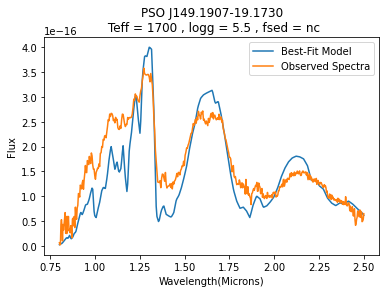

104/159:2MASSI J1213033-043243
6.253537404547744e-11 1.0


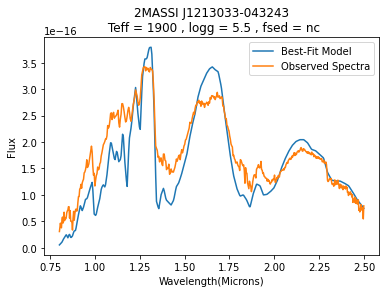

105/159:PSO J334.8034+11.2278
6.431061374608327e-12 1.0


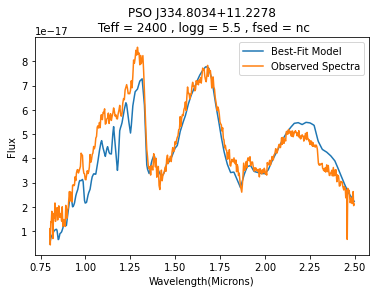

106/159:PSO J342.3797-16.4665
3.67578439245382e-11 0.9999999999999998


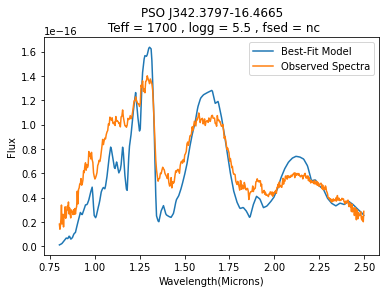

107/159:2MASS J17114559+4028578
8.727924110582299e-10 0.9999999999999998


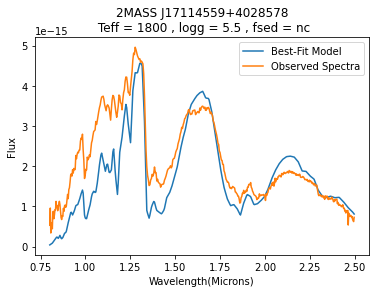

108/159:2MASSI J1305410+204639
4.387086382802379e-11 1.0000000000000002


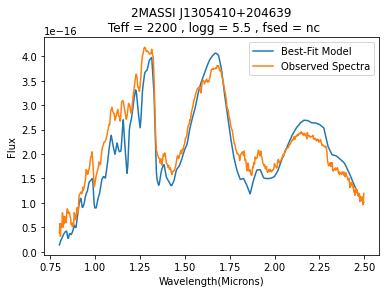

109/159:CC_CCv2.0_2855_97462
8.063008456900921e-12 0.9999999999999997


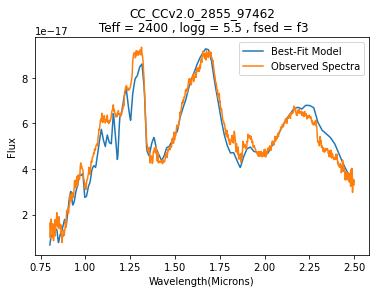

110/159:CC_CCv2.0_70689_107291
5.318689819449567e-12 0.9999999999999998


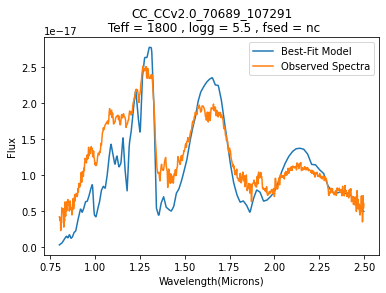

111/159:CC_CCv2.0_8674_30769
8.81668977042863e-12 1.0000000000000002


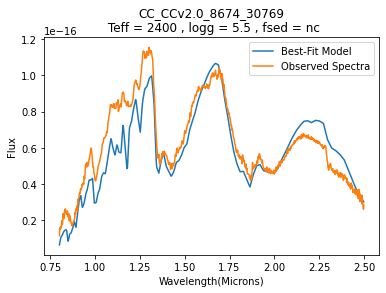

112/159:LHS 102BC
155106.6842411534 1.0000000000000007


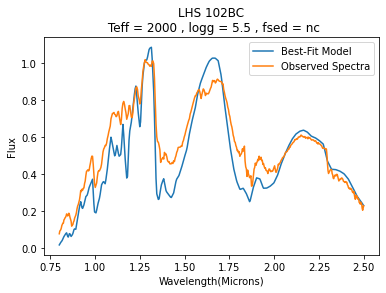

113/159:SDSS J080959.01+443422.2
92399.0121139291 1.0


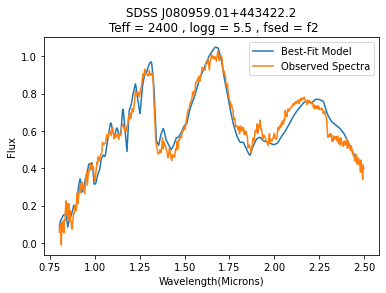

114/159:CC_CCv2.0_86045_65237
6.151660425395722e-12 0.9999999999999998


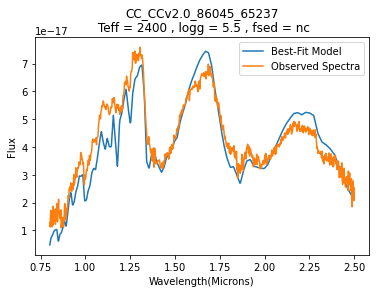

115/159:HIP 85365B
4.6924547775783735e-12 1.0


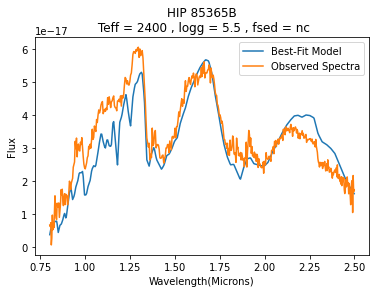

116/159:NLTT 55219B
1.6503530792397377e-11 0.9999999999999999


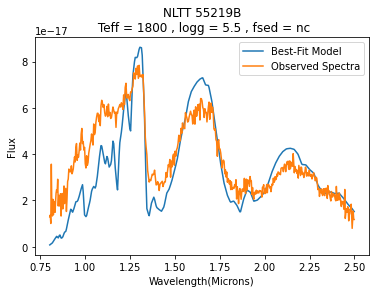

117/159:PSO J336.9036-18.9148
8.306579017006405e-12 1.0


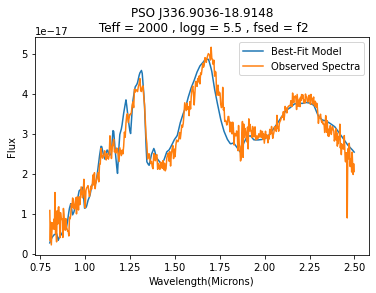

118/159:COCONUTS-3B
5.668865330536353e-12 1.0


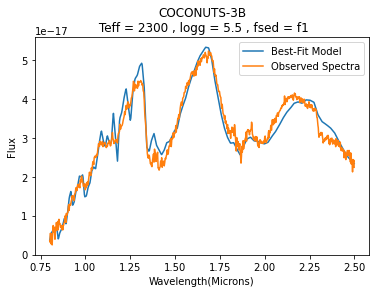

119/159:HIP 9269B
1.3641092550644298e-11 0.9999999999999998


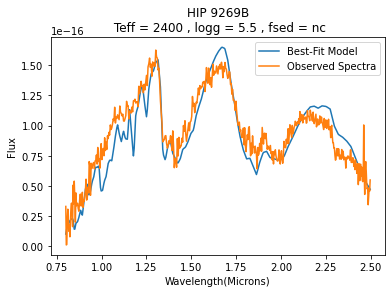

120/159:NLTT 31450B
8.172144349197462e-12 1.0


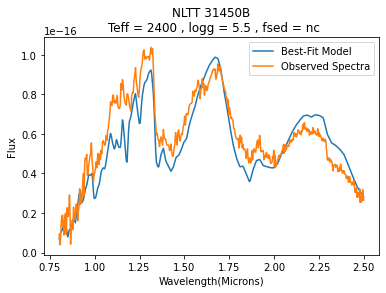

121/159:2MASSW J0850359+105716
7.424365587596907e-12 1.0000000000000002


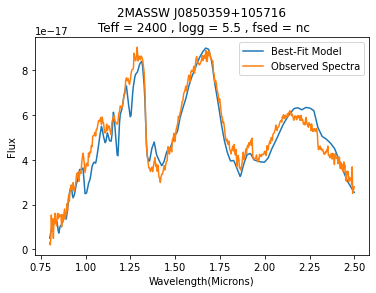

122/159:CC_CCv2.0_50329_99525
3.6206183146835615e-12 1.0000000000000002


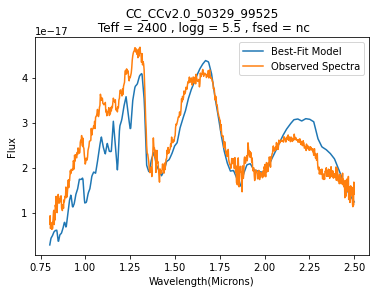

123/159:PSO J004.7148+51.8918
9.957518929252988e-12 1.0000000000000002


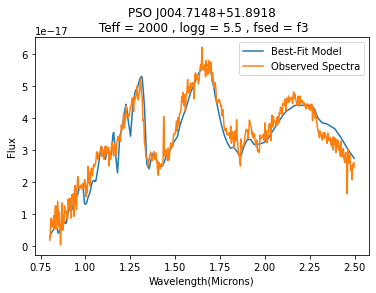

124/159:WISEP J004701.06+680352.1
8.5409359735105e-11 1.0000000000000002


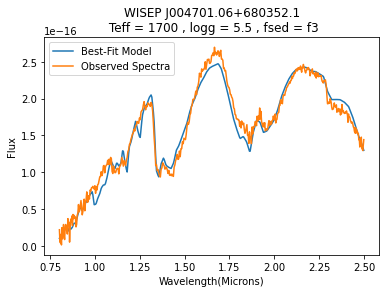

125/159:PSO J057.2893+15.2433
1.0782669835387448e-11 1.0


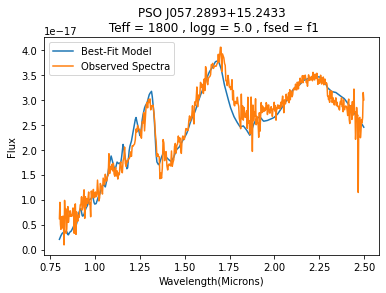

126/159:WISE J174102.78-464225.5
502833.6861560344 1.0


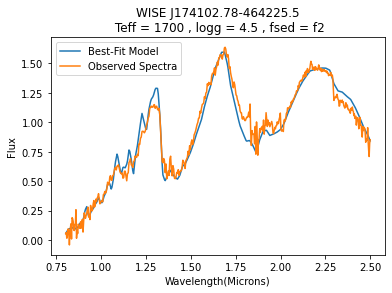

127/159:2MASS J00150206+2959323
202426.98270853682 1.0000000000000002


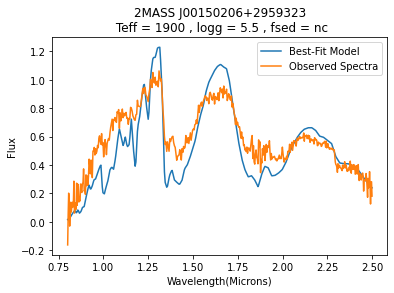

128/159:CC_CCv2.0_8969_96849
7.066416385923023e-12 1.0000000000000002


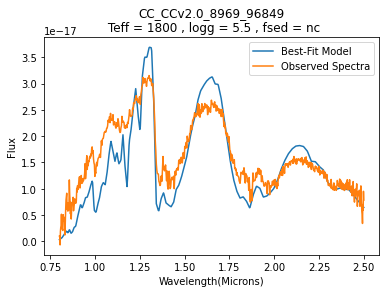

129/159:Gl 337CD
229101.70314047197 0.9999999999999999


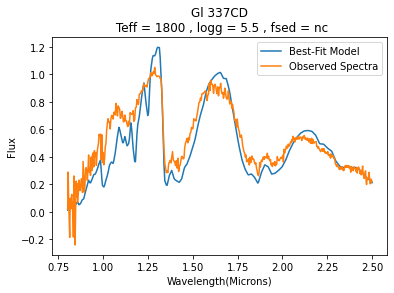

130/159:HD 203030B
4.367410480921401e-12 1.0000000000000002


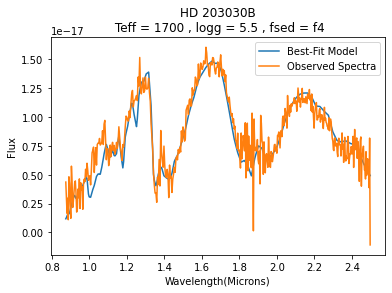

131/159:CC_CCv2.0_75870_10971
7.0641412679464925e-12 1.0000000000000002


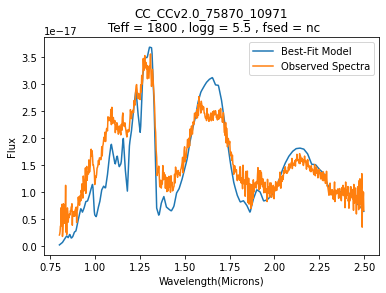

132/159:Gl 584C
117930.75890750802 1.0000000000000002


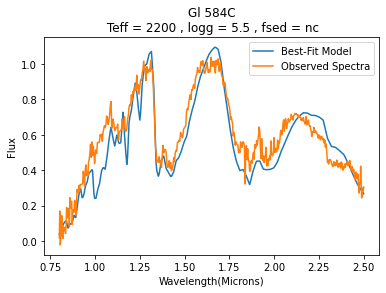

133/159:WISE J003110.04+574936.3
7.641040113018885e-11 1.0000000000000002


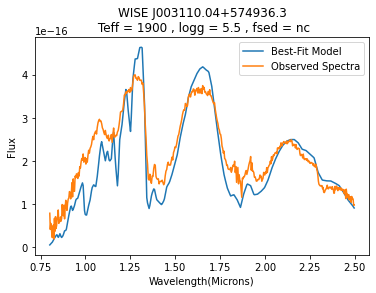

134/159:PM I23492+3458B
2.1788702199827607e-11 1.0


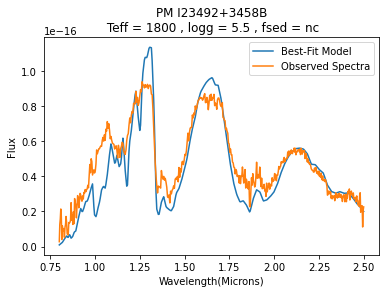

135/159:SDSS J213154.43-011939.3
186341.4968756619 1.0000000000000002


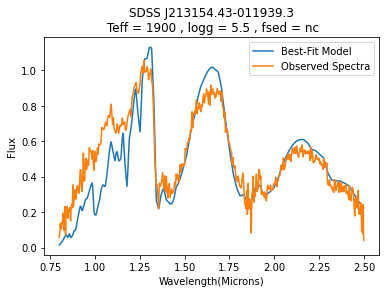

136/159:PSO J319.3102-29.6682
5.425836850641621e-11 0.9999999999999998


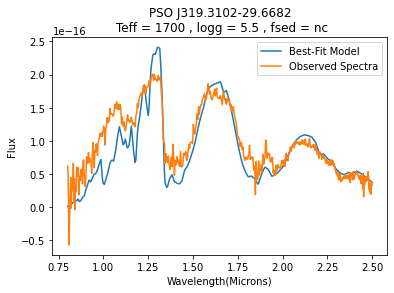

137/159:CC_CCv2.0_3380_112891
1.4206339635960758e-11 1.0


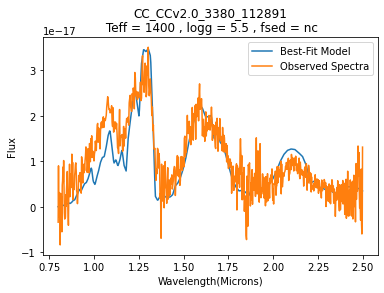

138/159:PSO J331.6058+33.0207
1.8037467610289738e-11 1.0000000000000002


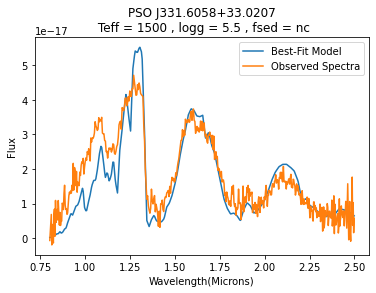

139/159:CC_CCv2.0_87605_109409
1.7614211247989955e-11 1.0000000000000002


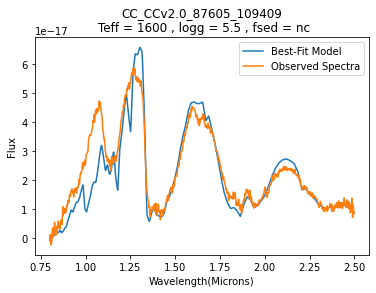

140/159:PSO J071.8769-12.2713
1.7876223995976376e-11 1.0


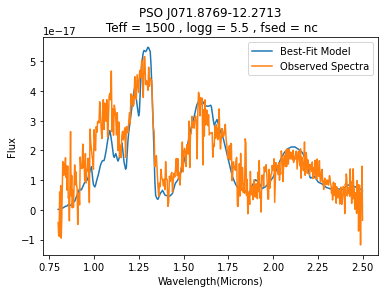

141/159:HN Peg B
1.0269694586913369e-09 1.0


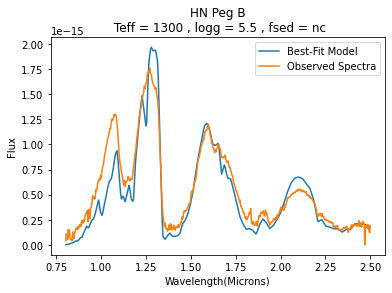

142/159:PSO J334.1193+19.8800
8.047095807452593e-11 1.0


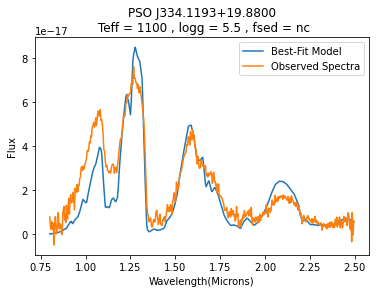

143/159:2MASS J02132062+3648506C
2.7025381876467015e-10 0.9999999999999999


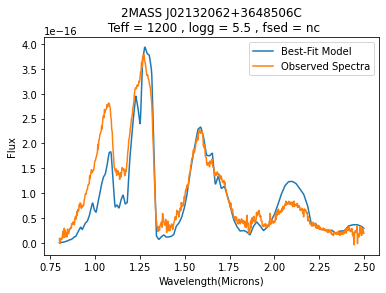

144/159:CC_CCv2.0_32207_32010
2.3637651426926897e-11 1.0000000000000002


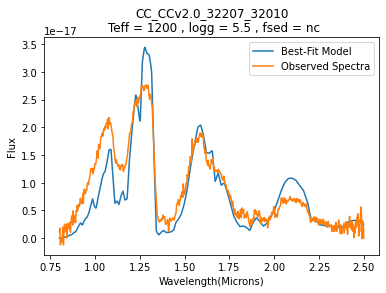

145/159:WISEPA J081958.05-033529.0
1652599.1347717077 1.0


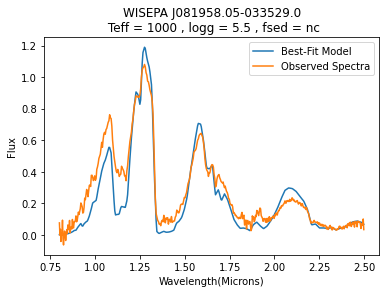

146/159:COCONUTS-1B
9.186391678017153e-11 1.0


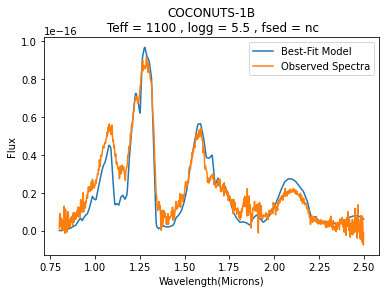

147/159:HIP 38939B
4.509483218252702e-10 1.0000000000000004


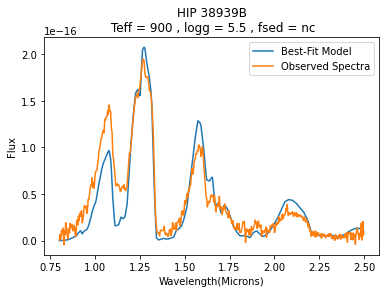

148/159:WISE J223617.59+510551.9
1.6734975097851176e-09 1.0000000000000002


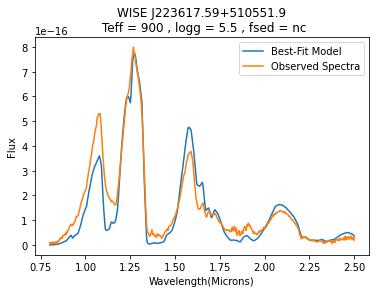

149/159:CC_CCv2.0_104593_84217
1.4624659511872468e-10 1.0


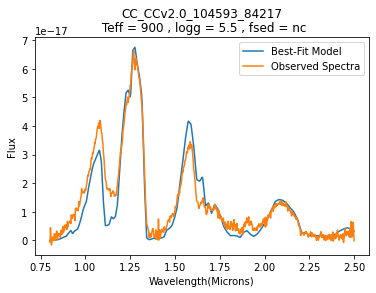

150/159:LHS 2803B
7.708898617840287e-10 0.9999999999999998


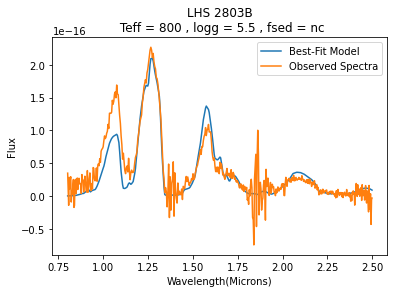

151/159:WISEPA J062720.07-111428.8
3567526.4976507705 0.9999999999999999


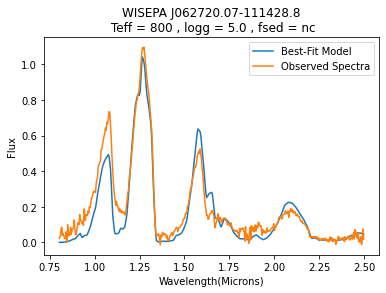

152/159:WISEPC J112254.73+255021.5
3497933.0058723683 0.9999999999999999


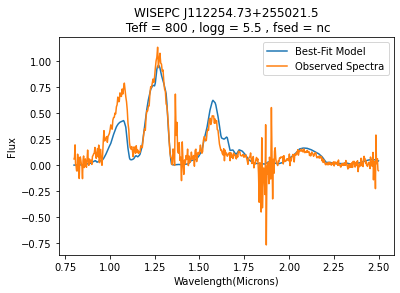

153/159:SDSS J175805.46+463311.9
3431386.5091313114 1.0


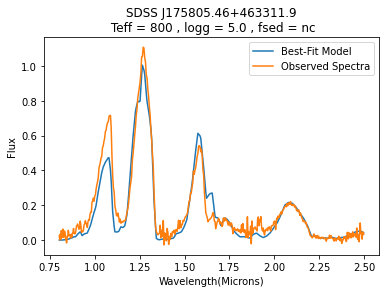

154/159:Gliese 570D
2356657.812595217 1.0000000000000002


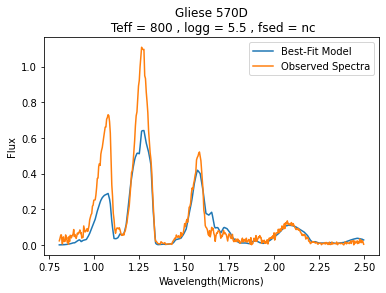

155/159:HD 3651B
3183994.4413622734 1.0000000000000002


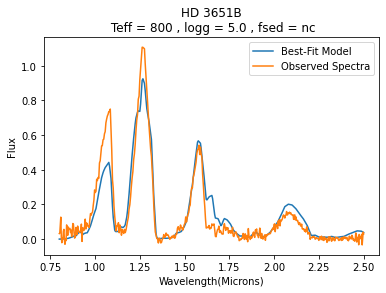

156/159:ULAS J141623.94+134836.3
1.7220435719031742e-10 1.0


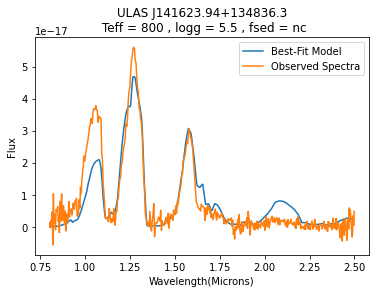

157/159:WISEPC J225540.74-311841.8
3119247.153941018 0.9999999999999997


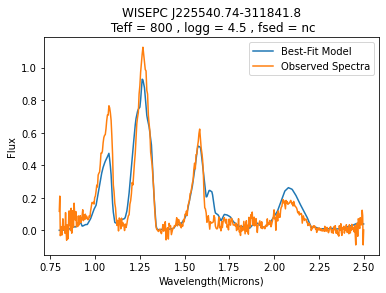

158/159:BD +01 2920B
2.5797798777307082e-11 1.0


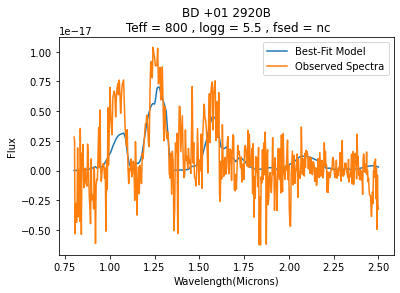

159/159:Ross 458C
3.821770612817719e-09 1.0


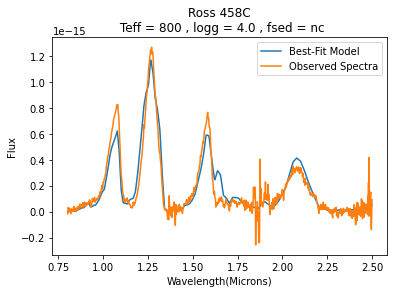

In [12]:
for index_object in range(num_object):
    current_object_name = name_object[index_object]
    print('%d/%d:%s'%(index_object + 1, num_object, current_object_name))
    
    # Load object spectra and names
    current_spectra_path = spectrum_path[index_object]
    txt_flag = True
    if current_spectra_path[-4:] == "fits":
        txt_flag = False
    current_fullspectra_path = '/Users/bosse/Pictures/Observed Spectra files/' + current_spectra_path
    if txt_flag: 
        data = np.loadtxt(current_fullspectra_path)
        w_data = data[:,0]
        f_data = data[:,1]
        u_data = data[:,2]
    else: 
        data = fits.open(current_fullspectra_path)[0].data
        w_data = data[0]
        f_data = data[1]
        u_data = data[2]
    id_good = np.where((np.isnan(f_data) == False) & (u_data != 0) & (w_data > 0.8) & (w_data < 2.5))
    w_data = w_data[id_good]
    f_data = f_data[id_good]
    u_data = u_data[id_good]
    Model_folder = '/Users/bosse/Pictures/Primary Grid Models/'
    C_k_1D_array = C_k_array[index_object]
    G_k_1D_array = G_k_array[index_object]
    IDbest = np.argmin(G_k_1D_array)
    teff_best, logg_best, f_sed_best = grid_param[IDbest]
    C_k_best = C_k_1D_array[IDbest]
    model_array_best = np.genfromtxt(Model_folder + "sp_t%dg%s%s"%(teff_best, logg_dict[logg_best], f_sed_dict[f_sed_best]), skip_header = 2)
    w_model_best = model_array_best[:,0]
    f_model_best = model_array_best[:,1]
    (new_w_model_best, new_f_model_best) = new_degrade_R(input_wl = w_model_best, input_fl = f_model_best, wl_range = [0.8,2.5], Res = 100)
    intfunc = spi.interp1d(new_w_model_best, new_f_model_best, fill_value="extrapolate")
    f_model_interp = intfunc(w_data)*C_k_best
    C_k_temp = np.sum(f_data * f_model_interp / u_data**2) / np.sum((f_model_interp**2)/(u_data**2))
    print(C_k_best, C_k_temp)
    plt.plot(w_data, f_model_interp, label = 'Best-Fit Model')  
    plt.plot(w_data, f_data, label = 'Observed Spectra')
#plt.fill_between(w_data, f_data - u_data, f_data + u_data, color='red', alpha=0.3)
    plt.title("%s\n Teff = %d , logg = %.1f , fsed = %s"%(current_object_name, teff_best, logg_best, f_sed_dict[f_sed_best]))
    plt.xlabel("Wavelength(Microns)")
    plt.ylabel("Flux")
    plt.legend()
    #plt.savefig("/Users/bosse/Pictures/Comparison Graphs/%s_model_vs_data.pdf"%(current_object_name),format = "pdf")
    #plt.close()
    plt.show()

1/159:2MASS J05575096-1359503


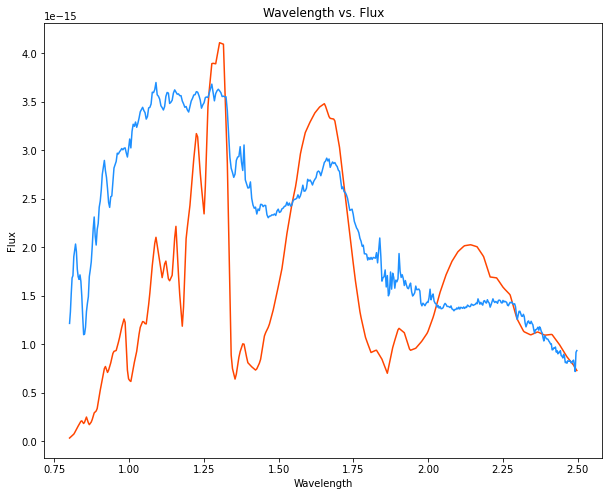

2/159:2MASS J23520507-1100435
3/159:CC_CCv2.0_4795_107418
4/159:CC_CCv2.0_68871_71463
5/159:2MASSI J0335020+234235
6/159:2MASS J06085283-2753583
7/159:2MASS J23231347-0244360
8/159:CC_CCv2.0_29902_75473
9/159:2MASS J00464841+0715177
10/159:2MASS J04433761+0002051
11/159:SDSS J102204.88+020047.5
12/159:2MASS J12474428-3816464
13/159:DENIS-P J154747.2-242349
14/159:2MASS J19355595-2846343
15/159:2MASS J20135152-2806020
16/159:PSO J337.4317+16.4213
17/159:2MASS J23453903+0055137
18/159:CC_CCv2.0_31709_104612
19/159:CC_CCv2.0_97406_93436
20/159:PC 0025+0447
21/159:EROS-MP J0032-4405
22/159:2MASSW J0058425-065123
23/159:2MASS J02411151-0326587
24/159:2MASSI J0316451-284852
25/159:2MASS J03231002-4631237
26/159:DENIS-P J035726.9-441730
27/159:2MASS J09532126-1014205
28/159:2MASS J11544223-3400390
29/159:2MASS J12074836-3900043
30/159:2MASSW J1552591+294849
31/159:PSO J348.8808+06.2873
32/159:2MASS J23224684-3133231
33/159:1RXS J235133.3+312720 B
34/159:G 239-25B
35/159:HD 89744B
36/159:SDSS 

In [13]:
figure, axis = plt.subplots(1,1, figsize=(10,8))
for index_object in range(num_object):
    current_object_name = name_object[index_object]
    print('%d/%d:%s'%(index_object + 1, num_object, current_object_name))
    
    # Load object spectra and names
    current_spectra_path = spectrum_path[index_object]
    txt_flag = True
    if current_spectra_path[-4:] == "fits":
        txt_flag = False
    current_fullspectra_path = '/Users/bosse/Pictures/Observed Spectra files/' + current_spectra_path
    if txt_flag: 
        data = np.loadtxt(current_fullspectra_path)
        w_data = data[:,0]
        f_data = data[:,1]
        u_data = data[:,2]
    else: 
        data = fits.open(current_fullspectra_path)[0].data
        w_data = data[0]
        f_data = data[1]
        u_data = data[2]
    id_good = np.where((np.isnan(f_data) == False) & (u_data != 0) & (w_data > 0.8) & (w_data < 2.5))
    w_data = w_data[id_good]
    f_data = f_data[id_good]
    u_data = u_data[id_good]
    Model_folder = '/Users/bosse/Pictures/Primary Grid Models/'
    C_k_1D_array = C_k_array[index_object]
    G_k_1D_array = G_k_array[index_object]
    IDbest = np.argmin(G_k_1D_array)
    teff_best, logg_best, f_sed_best = grid_param[IDbest]
    C_k_best = C_k_1D_array[IDbest]
    model_array_best = np.genfromtxt(Model_folder + "sp_t%dg%s%s"%(teff_best, logg_dict[logg_best], f_sed_dict[f_sed_best]), skip_header = 2)
    w_model_best = model_array_best[:,0]
    f_model_best = model_array_best[:,1]
    (new_w_model_best, new_f_model_best) = new_degrade_R(input_wl = w_model_best, input_fl = f_model_best, wl_range = [0.8,2.5], Res = 100)
    intfunc = spi.interp1d(new_w_model_best, new_f_model_best, fill_value="extrapolate")
    f_model_interp = intfunc(w_data)*C_k_best
    C_k_temp = np.sum(f_data * f_model_interp / u_data**2) / np.sum((f_model_interp**2)/(u_data**2))
    axis.plot(w_data, f_model_interp, markersize=10, color='orangered')
    axis.plot(w_data, f_data, markersize=10, color='dodgerblue')
    axis.set_title("Wavelength vs. Flux")
    axis.set_xlabel("Wavelength")
    axis.set_ylabel("Flux")
    plt.show();

In [ ]:
for index_object in range(num_object):
    current_object_name = name_object[index_object]
    print('%d/%d:%s'%(index_object + 1, num_object, current_object_name))
    #load G-k values
    G_k_object = G_k_array[index_object]
    #Rewrite grid points 
    logg_grid = np.array([4,4.5,5,5.5])
    f_sed_grid = np.array([1,2,3,4,10])
    #Scan Log(g) and F_sed
    for logg_value in logg_grid:
        for f_sed_value in f_sed_grid:
            IDslice = np.where(grid_param)((np.isnan(f_data) == False) & (u_data != 0) & (w_data > 0.8) & (w_data < 2.5))